## P1

In [2]:
pip install matplotlib


     ---------------------------------------- 7.2/7.2 MB 30.8 MB/s eta 0:00:00
     ------------------------------------- 161.3/161.3 kB 10.1 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 kB 3.0 MB/s eta 0:00:00
     ------------------------------------- 965.4/965.4 kB 63.7 MB/s eta 0:00:00


theta=60: score_SA 0.7205, score_SL 0.641


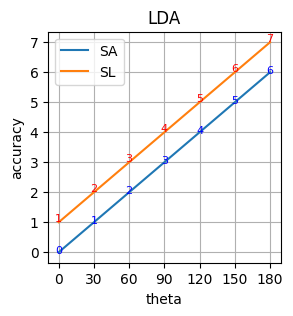

In [3]:
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


def generate_blob(mu,cov_root,N):
    # generate N samples with Gaussian distribution
    # mu: the mean vector, numpy array
    # cov_root: sqrt(covariance), numpy array
    D = len(mu)
    X = np.random.randn(N,D) @ cov_root.T + mu
    return X

def generate_data(N,ratio_pos=0.5,theta=0):
    # generate a mixture of two Gaussian blobs
    # N: number of samples
    # ratio_pos: P(y=1)
    # theta: the rotation angle for target domain, in degrees
    theta = theta/180*math.pi
    R = np.array([[math.cos(theta), math.sin(theta)], [-math.sin(theta), math.cos(theta)]])
    mu_pos = R @ np.array([-3,-1])
    cov_pos = R @ np.sqrt([[10,0],[0,1]])
    mu_neg = R @ np.array([3,1])
    cov_neg = R @ np.sqrt([[10,0],[0,1]])
    
    N_pos = int(N*ratio_pos)
    N_neg = N-N_pos
    X_pos = generate_blob(mu_pos, cov_pos, N_pos)
    X_neg = generate_blob(mu_neg, cov_neg, N_neg)
    X = np.concatenate((X_pos,X_neg), axis=0)
    Y = -np.ones((N,))
    Y[:N_pos] = 1
    return X,Y

def get_clf(Q,k=31):
    # return a base classifier
    # Q: name of classifier, str
    # k: number of neighbors for KNN
    if Q=='LDA':
        clf = LinearDiscriminantAnalysis()
    elif Q=='KNN':
        clf = KNeighborsClassifier(n_neighbors=k)
    elif Q=='SVM':
        clf = LinearSVC(random_state=0, tol=1e-5)
    else:
        clf = None
        print(f'Non-implemented clf {Q}')
    return clf

def standardize(X, mu=None, std=None):
    # standardize the data X with provided mu and std.
    # if mu or std is None, calculate mu and std from X.
    # X: [num_of_sample, feat_dim]
    if mu is None or std is None:
        mu = np.mean(X, axis=0)
        std = np.std(X, axis=0, ddof=1)
    X = (X-mu)/std
    return X, mu, std

def display(res_sa, res_sl, Q, k=31):
    # draw accuracy vs. theta for SA and SL on the same plot
    # res_sa, res_sl: list of accuracies
    # Q: name of classifier, str
    # k: number of neighbors for KNN
    plt.figure(figsize=(3,3))
    plt.plot(range(0,181,30), res_sa, label='SA')
    plt.plot(range(0,181,30), res_sl, label='SL')
    plt.xlabel('theta'), plt.ylabel('accuracy'), plt.title(f'{Q}' if Q!='KNN' else f'{Q},k={k}')
    plt.xticks(range(0,181,30))
    for i,theta in enumerate(range(0,181,30)):
        delta1 = 0.03 if res_sa[i]>=res_sl[i] else -0.05
        delta2 = -0.05 if res_sa[i]>=res_sl[i] else 0.03
        plt.text(theta, res_sa[i]+delta1, res_sa[i], size=8, color='b', ha="center")
        plt.text(theta, res_sl[i]+delta2, res_sl[i], size=8, color='r', ha="center")
    plt.grid('on')
    plt.legend()
    plt.show()
    return

def experiment(Ns=1000,Nt=1000,Ntest=2000,Ntl=20,theta=0,ratio_pos=0.5,Q='LDA',k=31,standardized=True,sign_flip=True):
    # return SA testing acc and SL testing acc, under the setting specified in arguments.
    # Ns: number of samples in source domain
    # Nt: number of samples in target domain
    # Nt: number of samples for testing in target domain
    # Ntl: number of labeled training samples in target domain
    # theta: the rotation angle for target domain, in degrees
    # ratio_pos: P(y=1)
    # Q: name of classifier, str
    # k: number of neighbors for KNN
    # standardized: standardize each feature dimension or not
    # sign_flip: flip the sign or not

    np.random.seed(2022)

    # TO-DO: draw Ds, DT, Dtest
    # notations: Xs, Ys, Xt, Yt, Xtest, Ytest
    Xs, Ys = generate_data(Ns, ratio_pos, 0)
    Xt, Yt = generate_data(Nt, ratio_pos, theta)
    Xtest, Ytest = generate_data(Ntest, ratio_pos, theta)
    # TO-DO: standardize Ds, DT, Dtest if needed
    if standardized:
        Xs = standardize(Xs)[0]
        Xt = standardize(Xt)[0]
        Xtest = standardize(Xtest)[0]

    # select Ntl points with labels, for sign flipping.
    # Xt, Yt are feature matrix and labels for target domain (after standardization if there is)
    Xtl = np.concatenate((Xt[:Ntl//2],Xt[-Ntl//2:]), axis=0)
    Ytl = np.concatenate((Yt[:Ntl//2],Yt[-Ntl//2:]), axis=0)
    
    # TO-DO: train and test SA
    # notations: score_SA (testing accuracy of SA, in [0,1])
    model = SA_ee660(get_clf(Q,k),2)
    if sign_flip and Ntl > 0:
        model.fit(Xs,Ys,Xt,Xtl,Ytl)
    else:
        model.fit(Xs,Ys,Xt,None,None)
    score_SA = model.score(Xtest,Ytest)
    # TO-DO: train and test SL
    # notations: score_SL (testing accuracy of SL, in [0,1])
    if sign_flip and Ntl > 0:
        Xs = np.vstack((Xs,Xtl))
        Ys = np.concatenate((Ys,Ytl))
    model = get_clf(Q,k)
    model.fit(Xs,Ys)
    score_SL = model.score(Xtest,Ytest)
    
    
    print(f'theta={theta}: score_SA {score_SA}, score_SL {score_SL}')
    return score_SA, score_SL

class SA_ee660:
    def __init__(self, estimator, n_components):
        # n_components: feature dimension after PCA
        self.estimator = estimator
        self.n_components = n_components
        self.sign_mtx = np.array([[1,0],[0,1]])
    
    def fit(self, Xs, Ys, Xt, Xtl=None, Ytl=None):
        # training of SA
        # Xs: source domain feature matrix, [Ns, D_feat]
        # Ys: labels in source domain
        # Xt: target domain feature matrix, [Nt, D_feat]
        # Xtl, Ytl: labeled target data. Do sign flipping if they are not None.

        self.pca_src_ = PCA(self.n_components)
        self.pca_src_.fit(Xs)
        self.pca_tgt_ = PCA(self.n_components)
        self.pca_tgt_.fit(Xt)

        self.M_  = self.pca_src_.components_ @ self.pca_tgt_.components_.T
        
        Xs_tf = self.transform(Xs, domain="src")
        self.estimator.fit(Xs_tf, Ys)
        
        if Xtl is not None and Ytl is not None:
            besti, bestj = 1, 1
            bestacc = 0
            for i in (1,-1):
                for j in (1,-1):
                    self.sign_mtx = np.array([[i,0],[0,j]])
                    acc = self.score(Xtl, Ytl)
                    if acc>bestacc:
                        bestacc, besti, bestj = acc, i, j
            self.sign_mtx = np.array([[besti,0],[0,bestj]])
        return
    
    def score(self, X, y):
        # test trained SA on testing set X and y
        # return the testing accuracy, value in [0,1]
        X_tf = self.transform(X, domain="tgt")
        if hasattr(self.estimator, "score"):
            score = self.estimator.score(X_tf, y)
        elif hasattr(self.estimator, "evaluate"):
            if np.prod(X.shape) <= 10**8:
                score = self.estimator.evaluate(X_tf, y, batch_size=len(X))
            else:
                score = self.estimator.evaluate(X_tf, y)
            if isinstance(score, (tuple, list)):
                score = score[0]
        else:
            raise ValueError("Estimator does not implement score or evaluate method")
        return score
    
    def transform(self, X, domain="tgt"):
        if domain in ["tgt"]:
            return self.pca_tgt_.transform(X) @ self.sign_mtx
        elif domain in ["src"]:
            return self.pca_src_.transform(X) @ self.M_
        else:
            raise ValueError("`domain `argument should be `tgt` or `src`, got, %s"%domain)

if __name__=="__main__":
    # always call the experiment function to get results for a certain setting.
    # Do not remove or change the random seed setting in that function so that your answers align with our solution.
    experiment(Ns=1000, Nt=1000, Ntest=2000, Ntl=20, theta=60, ratio_pos=0.5, Q='LDA', standardized=True,
               sign_flip=True)

    # example usage of the plotting function. Feel free to create your own.
    display([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7], Q='LDA')


In [5]:
pip install seaborn

     -------------------------------------- 288.2/288.2 kB 5.9 MB/s eta 0:00:00
     --------------------------------------- 10.9/10.9 MB 38.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


 ##  a

In [6]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
theta_list = [0, 30, 60, 90, 120, 150, 180]
model_list = ["LDA", "KNN", "SVM"]
N = 1000
ratio_p = 0.5
for theta in theta_list:
    Xs,Ys = generate_data(N=N, ratio_pos=ratio_p)
    Xt,Yt = generate_data(N=N, ratio_pos=ratio_p,theta=theta)
    plt.figure()
    N_pos = int(N * ratio_p)
    sns.scatterplot(Xt[:N_pos, 0], Xt[:N_pos, 1],
                    hue=None, marker='+',color="#FF8317", label="Xt +1",)
    sns.scatterplot(Xt[N_pos:, 0], Xt[N_pos:, 1],
                    hue=None, marker='_', color="#FF8317",label="Xt -1")
    sns.scatterplot(Xs[:N_pos, 0], Xs[:N_pos, 1], 
                    hue=None,marker='+',color="#1F77B4" ,label="Xs +1")
    sns.scatterplot(Xs[N_pos:, 0], Xs[N_pos:, 1], 
                    hue=None,marker='_', color="#1F77B4",label="Xs -1")
    plt.title(f"{theta}")
    plt.legend()
    plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given

<Figure size 640x480 with 0 Axes>

##  b

theta=0: score_SA 0.916, score_SL 0.916
theta=30: score_SA 0.687, score_SL 0.687
theta=60: score_SA 0.56, score_SL 0.56
theta=90: score_SA 0.461, score_SL 0.461
theta=120: score_SA 0.2325, score_SL 0.2325
theta=150: score_SA 0.152, score_SL 0.152
theta=180: score_SA 0.084, score_SL 0.084


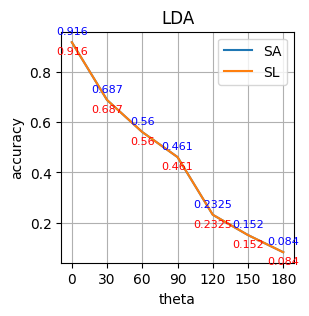

theta=0: score_SA 0.913, score_SL 0.913
theta=30: score_SA 0.6945, score_SL 0.6945
theta=60: score_SA 0.5825, score_SL 0.5825
theta=90: score_SA 0.474, score_SL 0.474
theta=120: score_SA 0.2215, score_SL 0.2215
theta=150: score_SA 0.148, score_SL 0.148
theta=180: score_SA 0.086, score_SL 0.086


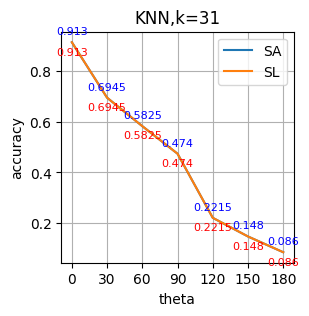

theta=0: score_SA 0.9165, score_SL 0.9165
theta=30: score_SA 0.6865, score_SL 0.6865
theta=60: score_SA 0.559, score_SL 0.559
theta=90: score_SA 0.4605, score_SL 0.4605
theta=120: score_SA 0.2325, score_SL 0.2325
theta=150: score_SA 0.152, score_SL 0.152
theta=180: score_SA 0.0835, score_SL 0.0835


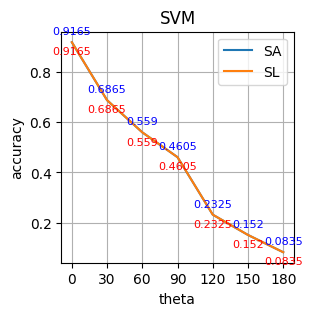

In [7]:
for Q in model_list:
    sa_scores = []
    sl_scores = []
    for theta in theta_list:
        sa, sl = experiment(Ns=1000,Nt=1000,Ntest=2000,Ntl=20,
                            theta=theta,ratio_pos=0.5,Q=Q,standardized=True,
                            sign_flip=False)
        sa_scores.append(sa)
        sl_scores.append(sl)
    display(sa_scores,sl_scores,Q,31)

### (b)iv from the rusults, we can see that SA performs as well as SL. 

##  c

theta=0: score_SA 0.916, score_SL 0.9165
theta=30: score_SA 0.811, score_SL 0.737
theta=60: score_SA 0.7205, score_SL 0.641
theta=90: score_SA 0.539, score_SL 0.5
theta=120: score_SA 0.7495, score_SL 0.234
theta=150: score_SA 0.848, score_SL 0.152
theta=180: score_SA 0.9095, score_SL 0.085


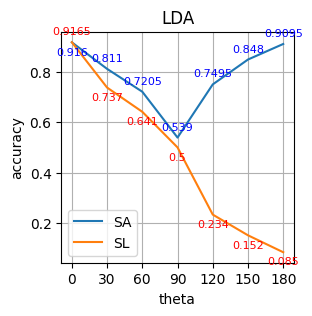

theta=0: score_SA 0.913, score_SL 0.9145
theta=30: score_SA 0.785, score_SL 0.7275
theta=60: score_SA 0.6925, score_SL 0.637
theta=90: score_SA 0.534, score_SL 0.4945
theta=120: score_SA 0.7765, score_SL 0.223
theta=150: score_SA 0.855, score_SL 0.1495
theta=180: score_SA 0.912, score_SL 0.0855


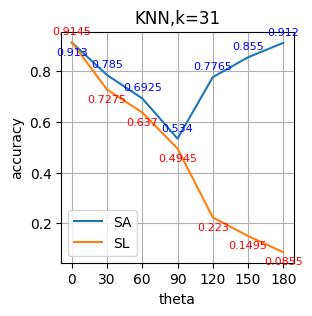

theta=0: score_SA 0.9165, score_SL 0.9165
theta=30: score_SA 0.8095, score_SL 0.7585
theta=60: score_SA 0.7215, score_SL 0.67
theta=90: score_SA 0.537, score_SL 0.514
theta=120: score_SA 0.749, score_SL 0.2335
theta=150: score_SA 0.847, score_SL 0.1515
theta=180: score_SA 0.911, score_SL 0.084


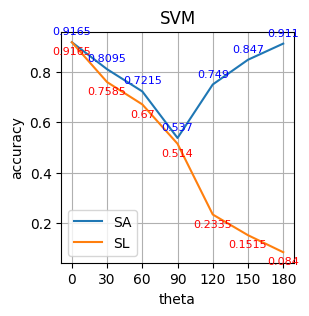

In [8]:
for Q in model_list:
    sa_scores = []
    sl_scores = []
    for theta in theta_list:
        sa, sl = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                            Ntl=20, theta=theta, ratio_pos=0.5, Q=Q,
                            standardized=True,sign_flip=True)
        sa_scores.append(sa)
        sl_scores.append(sl)
    display(sa_scores,sl_scores,Q,31)

### C(iv): SA performs better than SL. Yes, the sigh flip helps improve the performance of SA.  It is because label flipping is a training technique where one selectively manipulates the labels in order to make the model more robust against label noise and associated attacks - the specifics depend a lot on the nature of the noise. 

## d

theta=0: score_SA 0.916, score_SL 0.916
theta=30: score_SA 0.687, score_SL 0.687
theta=60: score_SA 0.56, score_SL 0.56
theta=90: score_SA 0.461, score_SL 0.461
theta=120: score_SA 0.2325, score_SL 0.2325
theta=150: score_SA 0.152, score_SL 0.152
theta=180: score_SA 0.084, score_SL 0.084
theta=0: score_SA 0.916, score_SL 0.916
theta=30: score_SA 0.687, score_SL 0.6995
theta=60: score_SA 0.7205, score_SL 0.5765
theta=90: score_SA 0.539, score_SL 0.473
theta=120: score_SA 0.7495, score_SL 0.233
theta=150: score_SA 0.848, score_SL 0.152
theta=180: score_SA 0.9095, score_SL 0.084
theta=0: score_SA 0.916, score_SL 0.9165
theta=30: score_SA 0.811, score_SL 0.737
theta=60: score_SA 0.7205, score_SL 0.641
theta=90: score_SA 0.539, score_SL 0.5
theta=120: score_SA 0.7495, score_SL 0.234
theta=150: score_SA 0.848, score_SL 0.152
theta=180: score_SA 0.9095, score_SL 0.085
theta=0: score_SA 0.9095, score_SL 0.917
theta=30: score_SA 0.811, score_SL 0.776
theta=60: score_SA 0.7205, score_SL 0.7055
t

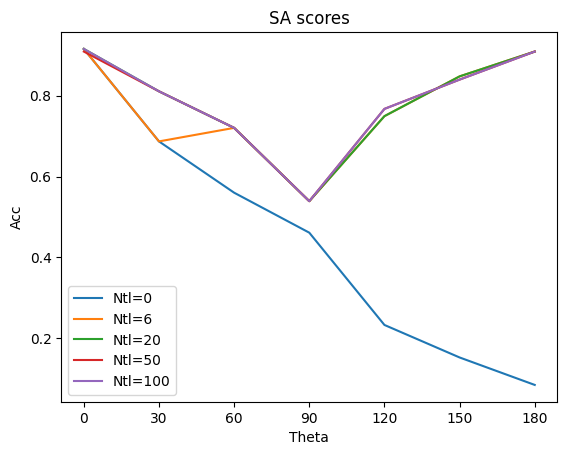

theta=0: score_SA 0.916, score_SL 0.916
theta=30: score_SA 0.687, score_SL 0.687
theta=60: score_SA 0.56, score_SL 0.56
theta=90: score_SA 0.461, score_SL 0.461
theta=120: score_SA 0.2325, score_SL 0.2325
theta=150: score_SA 0.152, score_SL 0.152
theta=180: score_SA 0.084, score_SL 0.084
theta=0: score_SA 0.916, score_SL 0.916
theta=30: score_SA 0.687, score_SL 0.6995
theta=60: score_SA 0.7205, score_SL 0.5765
theta=90: score_SA 0.539, score_SL 0.473
theta=120: score_SA 0.7495, score_SL 0.233
theta=150: score_SA 0.848, score_SL 0.152
theta=180: score_SA 0.9095, score_SL 0.084
theta=0: score_SA 0.916, score_SL 0.9165
theta=30: score_SA 0.811, score_SL 0.737
theta=60: score_SA 0.7205, score_SL 0.641
theta=90: score_SA 0.539, score_SL 0.5
theta=120: score_SA 0.7495, score_SL 0.234
theta=150: score_SA 0.848, score_SL 0.152
theta=180: score_SA 0.9095, score_SL 0.085
theta=0: score_SA 0.9095, score_SL 0.917
theta=30: score_SA 0.811, score_SL 0.776
theta=60: score_SA 0.7205, score_SL 0.7055
t

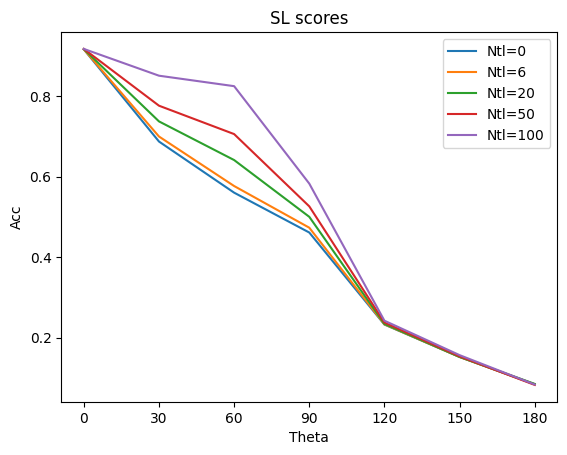

In [9]:
plt.figure()
for Ntl in [0, 6, 20, 50, 100]:
    scores = []
    for theta in theta_list:
        score, _ = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                              Ntl=Ntl, theta=theta, ratio_pos=0.5, 
                              Q="LDA",standardized=True,sign_flip=True)
        scores.append(score)
    plt.plot(theta_list, scores, label=f"Ntl={Ntl}")
plt.xlabel('Theta')
plt.ylabel('Acc')
plt.title('SA scores')
plt.xticks(theta_list)
plt.legend()
plt.show()

plt.figure()
for Ntl in [0, 6, 20, 50, 100]:
    scores = []
    for theta in theta_list:
        _, score = experiment(Ns=1000, Nt=1000, 
                              Ntest=2000, Ntl=Ntl, theta=theta, ratio_pos=0.5, 
                              Q="LDA",standardized=True,sign_flip=True)
        scores.append(score)
    plt.plot(theta_list, scores, label=f"Ntl={Ntl}")
plt.xlabel('Theta')
plt.ylabel('Acc')
plt.title('SL scores')
plt.xticks(theta_list)
plt.legend()
plt.show()

### d(iii) When the Ntl increases, the performance of SA adn SL becomes better.

##  e

In [10]:
score_SA, score_SL = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                                Ntl=20, theta=30, ratio_pos=0.5, 
                                Q="LDA", standardized=False, sign_flip=True)
print(f"sign_flip:✔\tstandardized:×")
print("SA:",score_SA)
print("SL:",score_SL)
print("\n")
score_SA, score_SL = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                                Ntl=20, theta=30, ratio_pos=0.5, 
                                Q="LDA", standardized=True, sign_flip=True)
print(f"sign_flip:✔\tstandardized:✔")
print("SA:",score_SA)
print("SL:",score_SL)
print("\n")

score_SA, score_SL = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                                Ntl=20, theta=30, ratio_pos=0.5, 
                                Q="LDA", standardized=False, sign_flip=False)
print(f"sign_flip:×\tstandardized:×")
print("SA:",score_SA)
print("SL:",score_SL)
print("\n")

score_SA, score_SL = experiment(Ns=1000, Nt=1000, Ntest=2000, 
                                Ntl=20, theta=30, ratio_pos=0.5, 
                                Q="LDA", standardized=True, sign_flip=False)
print(f"sign_flip:×\tstandardized:✔")
print("SA:",score_SA)
print("SL:",score_SL)

theta=30: score_SA 0.7685, score_SL 0.6105
sign_flip:✔	standardized:×
SA: 0.7685
SL: 0.6105


theta=30: score_SA 0.811, score_SL 0.737
sign_flip:✔	standardized:✔
SA: 0.811
SL: 0.737


theta=30: score_SA 0.561, score_SL 0.56
sign_flip:×	standardized:×
SA: 0.561
SL: 0.56


theta=30: score_SA 0.687, score_SL 0.687
sign_flip:×	standardized:✔
SA: 0.687
SL: 0.687


## The standardization increase the accuracy. It is because standardized data is essential for accurate data analysis

## P2

In [11]:
from matplotlib import pyplot as plt
import numpy as np

In [12]:
def E_ab(N_t,N_s,alpha,print_flag):
    d_vc=10
    tol=0.1
    diff_measure=0.1
    total_labeled=N_t+N_s
    beta=N_t/total_labeled
    formula_1=2*(1-alpha)*(0.5*diff_measure)
    formula_2_i=4*np.sqrt(((alpha*alpha)/beta)+(((1-alpha)*(1-alpha))/(1-beta)))
    formula_2_ii=np.sqrt((2*d_vc*np.log(2*(total_labeled+1))/total_labeled)
                      +(2*np.log(8/tol)/total_labeled))
    formula_2=formula_2_i*formula_2_ii
    e_ab=formula_1+formula_2
    if print_flag==True:
        print("E_ab for N_t ({}), N_s ({}), alpha ({}) = {:.2f}"
              .format(N_t,N_s,alpha,e_ab))
    return e_ab

## a(i)

In [13]:
n_t=1
n_s=100
alphas=[0.1,0.5,0.9]
for a in alphas: 
    E_ab(n_t,n_s,a,True)

E_ab for N_t (1), N_s (100), alpha (0.1) = 5.86
E_ab for N_t (1), N_s (100), alpha (0.5) = 21.62
E_ab for N_t (1), N_s (100), alpha (0.9) = 38.64


## a(ii)

In [14]:
n_t=10
n_s=1000
alphas=[0.1,0.5,0.9]
for a in alphas:
    E_ab(n_t,n_s,a,True)

E_ab for N_t (10), N_s (1000), alpha (0.1) = 2.25
E_ab for N_t (10), N_s (1000), alpha (0.5) = 8.12
E_ab for N_t (10), N_s (1000), alpha (0.9) = 14.46


## a(iii)

In [15]:
n_t=100
n_s=10000
alphas=[0.1,0.5,0.9]
for a in alphas:
    E_ab(n_t,n_s,a,True)

E_ab for N_t (100), N_s (10000), alpha (0.1) = 0.86
E_ab for N_t (100), N_s (10000), alpha (0.5) = 2.94
E_ab for N_t (100), N_s (10000), alpha (0.9) = 5.19


## a(iv)

In [16]:
n_t=1000
n_s=100000
alphas=[0.1,0.5,0.9]
for a in alphas:
    E_ab(n_t,n_s,a,True)

E_ab for N_t (1000), N_s (100000), alpha (0.1) = 0.36
E_ab for N_t (1000), N_s (100000), alpha (0.5) = 1.06
E_ab for N_t (1000), N_s (100000), alpha (0.9) = 1.82


##  a(v) Only one of the sets of numbers (N_t = 1000, N_s = 100000, alpha=0.1) above assure degree of generalization(e_ab<0.5).

## b

Optimal value of alpha for N_t (10)
0.0204
Optimal value of alpha for N_t (100)
0.1020
Optimal value of alpha for N_t (1000)
0.5306
Optimal value of alpha for N_t (10000)
0.9184


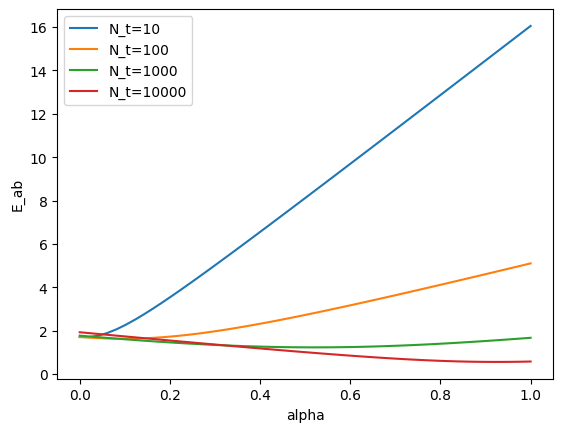

In [17]:
n_t=[10,100,1000,10000]
n_s=1000
alphas=np.linspace(0,1)
for n in n_t:
    e_ab_n=[]
    for a in alphas:
        val=E_ab(n,n_s,a,False)
        e_ab_n.append(val)
    plt.plot(alphas,e_ab_n)
    plt.legend(["N_t=10","N_t=100","N_t=1000","N_t=10000"])
    plt.xlabel("alpha")
    plt.ylabel("E_ab")
    idx=np.argmin(e_ab_n)
    print("Optimal value of alpha for N_t ({})".format(n))
    print("{:.4f}".format(alphas[idx]))

## (1)With greater number of labeled data points in target do main, importance of error in target domain increases with constant numberof labeled points in source domain since our goal is to adapt the target do main and generalize better in target domain.
## (2)For a specific value of N_t, once the optimum valueof alpha is reached, generalization error bound increases. 
## (3)When N_t increases, optimum value of alpha increases.

## (c)

Optimal value of alpha for N_s (10) = 0.9184
Optimal value of alpha for N_s (100) = 0.5102
Optimal value of alpha for N_s (1000) = 0.1020
Optimal value of alpha for N_s (10000) = 0.0204


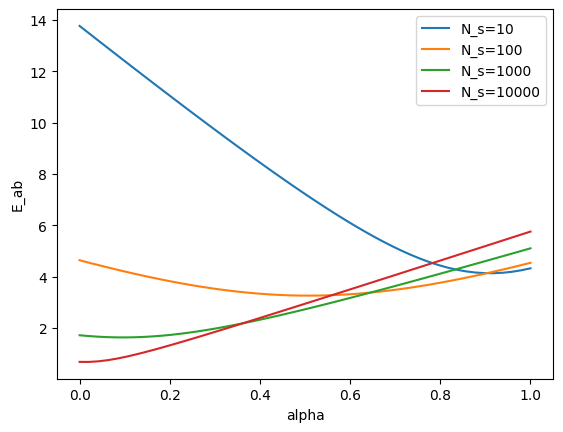

In [18]:
n_t=100
n_s=[10,100,1000,10000]
alphas=np.linspace(0,1)
for n in n_s:
    e_ab_n=[]
    for a in alphas:
        val=E_ab(n_t,n,a,False)
        e_ab_n.append(val)
    plt.plot(alphas,e_ab_n)
    plt.legend(["N_s=10","N_s=100","N_s=1000","N_s=10000"])
    plt.xlabel("alpha")
    plt.ylabel("E_ab")
    idx=np.argmin(e_ab_n)
    print("Optimal value of alpha for N_s ({}) = {:.4f}".format(n,alphas[idx]))


## (1)It can be observed that for a specific value of N_s (10), E_ab decreasesas alpha increases till the optimum value is reached. For N_s (100,100,10000),E_ab increases as alpha increase once the optimum value is reached andhence tends to have a very low alpha.

## (2) When N_s increases, optimum value of alpha decreases, hence givinghigher importance to error in source domain.

## d(iii)

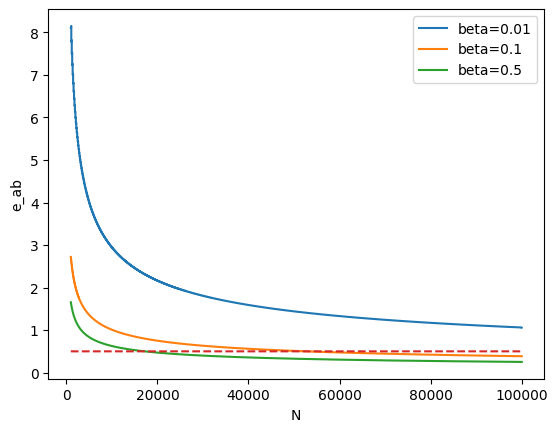

In [19]:
alpha_=0.5
N=list(range(1000,100001))
beta=[0.01,0.1,0.5]
for b in beta:
    e_ab_beta=[]
    for n in N:
        N_t=int(b*n)
        N_s=n-N_t
        val=E_ab(N_t,N_s,alpha_,False)
        e_ab_beta.append(val)
    plt.plot(N,e_ab_beta)
plt.plot(N,[0.5]*len(N),'--')
plt.xlabel("N")
plt.ylabel("e_ab")
plt.legend(["beta=0.01","beta=0.1","beta=0.5"])
plt.show()

 ## d(iii) (alpha =beta)

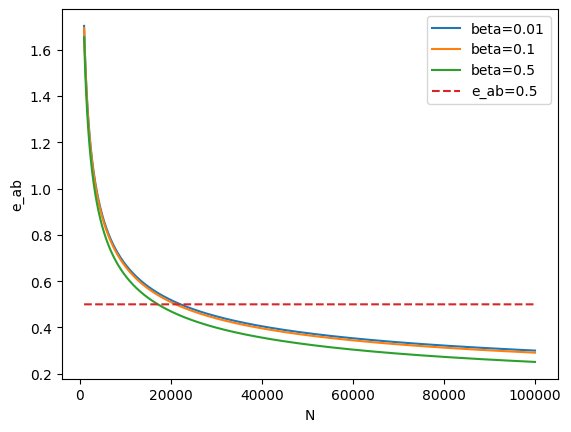

In [20]:
N=list(range(1000,100001))
beta=[0.01,0.1,0.5]
for b in beta:
    e_ab_beta=[]
    for n in N:
        N_t=int(b*n)
        N_s=n-N_t
        val=E_ab(N_t,N_s,b,False)
        e_ab_beta.append(val)
    plt.plot(N,e_ab_beta)
plt.xlabel("N")
plt.ylabel("e_ab")
plt.plot(N,[0.5]*len(N),'--')
plt.legend(["beta=0.01","beta=0.1","beta=0.5","e_ab=0.5"])
plt.show()

## d(i) Compared to the above plots, we can say that Alpha=beta is a better choice in terms of minimizing the cross-domain error even for beta<1/2

## d(ii) beta>1/2, E_ab(alpha=beta) <E_ab(alpha=0.5). 

## d(iii)In conclusion, alpha=beta is a good default choice when minimizing cross-domain generalization error bounds


## (e) Generalization error could be measured by MSE. As the model capacity increases, the bias decreases as the model fits the training datasets better.